In [1]:
import re
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [2]:
total_df = pd.read_csv('../data/team/5_interest_rate.csv')

/tmp/ipykernel_1660704/3485981028.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('../data/team/5_interest_rate.csv')


In [3]:
print(total_df.shape)
print(total_df.columns)

(1128094, 76)
Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)',
       'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', '시군구 번지', '좌표X,좌표Y', '가장 가까운 거리', 'index',
       '역사_ID', '역사명', '호선', '위도', '경도', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리',
       '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호',
       '가장 가까운 버스 정류소명', '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표',
       '가장 가까운 버스 정류장 Y좌표', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리'],
      dtype='obj

In [4]:
# 추가로 제거가 필요한 feature 제거
total_df.drop([
    # '시군구', 
    # '번지',
    # '도로명',
    # '아파트명', 
    # 'k-건설사(시공사)',
    '본번',
    '부번',
    'k-세대타입(분양형태)', 
    '거래유형', 
    'k-시행사', 
    'k-연면적', 
    'k-주거전용면적',
    'k-관리방식',
    '해제사유발생일',
    '등기신청일자',
    '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-복도유형', 'k-난방방식', 'k-전체동수',
    '세대전기계약방법', '청소비관리형태', '건축면적', 'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', '시군구 번지', 
    '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
    '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
    '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '호선',
    'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자',
    'k-수정일자', '고용보험관리번호', '경비비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
    '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일',
    '계약년', '계약월',
], axis=1, inplace=True)

display(total_df.shape)
display(total_df.columns)

(1128094, 20)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-전체세대수', 'k-건설사(시공사)', '주차대수', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리'],
      dtype='object')

In [5]:
total_df['세대별_주차대수'] = total_df['주차대수'] / total_df['k-전체세대수']

total_df.drop(['주차대수', 'k-전체세대수'], axis=1, inplace=True)
display(total_df.shape)
display(total_df.columns)

(1128094, 19)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-건설사(시공사)', 'target', 'is_test', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '세대별_주차대수'],
      dtype='object')

In [6]:
# 동의어 사전
synonyms = {
    '삼성물산': ['삼성물산주식회사', '삼성물산(주)', '삼성물산 건설부문', '삼성물산(주) 건설부문', '삼성물산,두산건설', '삼성물산(주) 주택부문', "삼성건설", "삼성건설(주)", "삼성래미안", "삼성물산",
               "(주)삼성물산", "삼성", "삼성물산", "삼성중공업", "(주)삼성", "삼성물산, 건설부문", "삼성물산, 주택부문"],
    '현대건설': ['현대건설(주)', '현대건설주식회사', '(주)현대건설', '현대산업개발', '현대산업개발(주)', 'HDC현대산업개발', '현대bs&c', '현대BS&C', "(주)현대산업개발", "현대산업개발", 
               "주식회사 현대건설", "현대", "현대산업개발 주", "현대종합건설", "주시회사 현대건설", "현대산업개발", "현대엔지니어링", "현대힐스테이트", "주시회사, 현대건설", "현대건설, 주"],
    '대림산업': ['대림산업(주)', '대림산업주식회사', '(주)대림산업', '대림건설', '대림건설(주)', "(주)대림", "대림", "대림산업", "대림산업 (주)", "대림산업"],
    '대우건설': ['대우건설(주)', '대우푸르지오', "(주)대우", "(주)대우건설", "대우건설", "주)대우건설", "대우경남", "대우", "대우자동차판매"],
    'GS건설': ['GS건설(주)', '지에스 건설', '지에스건설주식회사', '지에스건설(주)', "(주)gs공사", "GS 건설", "GS건설", "GS건설주식회사", "GS자이 건설", "gs건설", "럭키외", "GS", "gs공사",
              'GS건설, unknown', 'GS자이, unknown', "지에스, unknown", '지에스건설'],
    "SK건설": ["(주)에스케이건설", "SK", "에스케이건설"],
    '한라건설': ['(주)한라', '한라건설', '(주)한라건설', '한라'],
    '롯데건설': ['롯데건설(주)', '롯데건설주식회사', "(주)롯데건설", "롯데건설"],
    '한화건설': ['(주)한화건설', '한화건설(주)'],
    '두산건설': ['두산건설주식회사', '두산건설(주)', "두산", "두산건설", "두산건설(주)", "두산건설주식회사"],
    '우성건설': ['우성건설(주)', '(주)우성건설', '우성건설(주)'],
    '포스코건설': ['(주)포스코건설', '포스코, 포스코A&C', '포스코', '포스코', '포스코건설, 포스코A&C'],
    'SH공사': ['sh공사', '에스에이치공사', 'SH', "SH공사", "sh 공사", "sh, 공사", "(주)에스에이치건설", "서울도시개발공사", "주택공사", "도시개발공사", "에스에이치건설"],
    '건영건설': ['(주)건영', '(주) 건영', "(주) 건영", "건영", "건영건설", "건영종합건설(주)", " (주) 건영", "건영종합건설"],
    '신동아건설': ['신동아건설(주)', '신동아 건설(주)', '신동아', '신동아건설', '신동아건설(주)', "신동아건설, unknown"],
    '계룡건설': ['계룡건설(주)', '계룡건설산업(주)'],
    '코오롱건설': ['코오롱글로벌(주)', '코오롱글로벌', '코오롱건설주식회사'],
    '성원건설': ['성원건설(주)', '(주)성원건설'],
    "금호건설": ["(주)금호", "(주)금호건설", "(주)금호산업", "금호", "금호건설", "금호건설(주)", "금호산업", "금호자이"],
    "동아건설": ["(주)동아건설산업", "동아건설", "동아건설산업(주)", "동아건설산업"],
    "동일토건": ["(주)동일토건", "동일토건"],
    "LG건설": ["엘지건설(주)", "엘지건설"],
    "한일건설" : ["한일개발"],
    "삼호건설": ["삼호건설", "삼호주택", "(주)삼호"],
    "서광산업": ["(주)서광건설산업", "서광산업"],
    "서희건설": ["(주)서희건설", "서희건설", "주식회사 서희건설", 'unknown, 서희건설'],
    "신성건설": ["(주)신성건설", "신성건설", "신성건설(주)"],
    "신창건설": ["(주)신창건설", "신창건설", "신창건설(주)->우방건설", "신창건설->우방건설"],
    "쌍용건설": ["(주)쌍용건설", "쌍용건설", "쌍용건설(주)", "쌍용건설(주)", "쌍용"],
    "우방건설": ["(주)우방", "우방", "우방건설"],
    "우리건설": ["(주)우리건설", "우리건설", "우리창우"],
    "일성건설": ["(주)일성건설", "일성건설", "(주)일성건설"],
    "임광건설": ["임광토건(주)"],
    "청구건설": ["청구", "청구주택"],
    "남광건설" : ["남광", "남광토건(주)", "남광토건"],
    "풍림건설" : ["풍림산업"],
    "중앙건설": ["(주)중앙건설", "중앙건설", "중앙건설(주)"],
    "태영건설": ["(주)태영", "(주)태영건설", "태영건설", "태영"],
    "한양건설": ["(주)한양", "(주)한양건설", "한양", "한양건설", "한양", "한양건설", "한양수자인", "한양주택 (주)", "?양건설", "한양산업개발", "한양산업개발(주", "한양주택"],
    "한진건설": ["(주)한진중공업", "한진중공업", "한진중공업(주)", "한진중공업", "한진건설(주)"],
    "한신건설": ["한신공영", "한신공영(주)"],
    "효성건설": ["(주)효성", "(주)효성건설", "효성건설", "효성중공업", "효성"],
    "KCC건설": ["KCC", "kcc건설"],
    "동부건설": ["동부건설", "동부건설(주)", "동부건설(주)외1", "동부건설외1"],
    "이수건설": ["이수건설", "이수건설(주)", "이수건설,대우엔지니어링"],
    "삼성중공업": ["삼성중공업", "삼성중공업(주)"],
    "호반건설" : ["(주)호반건설"],
    "LIG건설" : ["LIG건설", "LIG건설(주)"],
    "경남기업": ["경남기업", "경남기업(주)"],
    "경향건설": ["경향건설(주)"],
    "계룡건설": ["계룡건설산업", "계룡건설(주)", "계룡건설산업(주)"],
    "고려개발": ["고려개발", "고려개발(주)", "고려산업개발", "고려산업개발(주)", "고려개발(주)", "고려산업개발", "고려산업개발(주)"],
    "극동건설" : ["극동건설", "극동건설(주)"],
    "나산건설" : ["나산종합건설"],
    "라이프건설": ["라이프주택"],
    "신도건설": ["(주)신도종합건설", "신도종합건설"],
    "쌍용건설": ["쌍용"],
    "우림건설": ["우림건설", "우림건설(주)"],
    "유원건설": ["유원건설", "유원건설(주)", '울트라건설', '울트라건설(주)', "유원울트라", "유원"],
    "월드건설": ['월드건설', '월드건설(주)'],
    '인정건설' : ['인정건설', '인정건설(주)'],
    "흥화건설": ["흥화공업", "흥화공업(주)"],
    "한솔건설": ["한솔"],
    "한보건설": ["한보", "한보철강", "한보철강", '한보철상'],
    "고려개발": ["고려개발 "],
    "동양메이저건설": ["동양메이저(주)", "동양고속건설주식회사", "동양메이저"],
    "동일건설": ["동일토건", "동일하이빌", "동일", "동일하이빌"],
    "두산건설": ["두산", "두산중공업"],
    "미주건설": ["미주실업주식회사", "미주실업"],
    "벽산건설": ["벽산건설(주)"],
    "삼익건설": ["삼익주택(주)", "삼익주택", "삼익주택(주)", "삼익건설(주)", "unknown, 삼익건설", "청담삼익아파트"],
    "삼정건설": ["삼정기업"],
    "삼환건설": ["삼환기업", "삼환"],
    "세양건설": ["세양건설산업"],
    "신동아건설": ['신동아'],
    "양우건설": ['양우건설(주)', "양우건설사"],
    "우성건설": ["우성"],
    "우정건설": ["우정건설 주식회사", "우정건설, unknown"],
    "중앙건설": ["중앙하이츠", "중앙건설(주)"],
    "진흥건설": ["진흥기업", "진흥연립재건축조합", "진흥기업", "(주)진흥기업", "진흥기업", "진흥기업(주)", "진흥기업"],
    '풍림건설': ['풍림산업(주)', '풍림산업'],
    "신일건업": ['신일산업', '(주)신일건업'],
    "동일건설": ['동일토건', '동일'],
    '세양건설': ['세양건설산업(주)'],
    '라이프건설' : ['라이프주택'],
    '미주건설' : ['미주실업'],
    '선경건설' : ['선경'],
    "unknown" : ['(주)', '주식회사', '건설', 'nan', '박연정', '재건축조합']
}

# (주) 제거하는 함수
def remove_corporate_suffix(name):
    return name.replace('(주)', '').strip()

# 여러 구분자를 처리하는 정규 표현식 패턴
def split_builders(builders):
    pattern = re.compile(r'[\/,\s]+')
    return pattern.split(builders.strip())

# 동의어 대체 함수
def replace_synonyms(value, synonyms_dict):
    for key, values in synonyms_dict.items():
        if value in values:
            return key
    return value

# 여러 문자열을 처리하는 함수
def process_builders(builders, synonyms_dict):
    builders_list = split_builders(builders)
    processed_list = [replace_synonyms(builder, synonyms_dict) for builder in builders_list]
    return ', '.join(processed_list)


# 문자열이 아닌 값을 문자열로 변환
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(lambda x: str(x) if not isinstance(x, str) else x)

# (주) 제거
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(remove_corporate_suffix)

# 동의어 처리 및 리스트를 문자열로 변환
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(lambda x: process_builders(x, synonyms))

In [7]:
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].replace({
    'GS건설, unknown': 'GS건설',
    'GS자이, unknown': 'GS건설',
    'unknown, 삼익건설' : '삼익건설',
    'unknown, 서희건설' : '서희건설',
    '고려산업개발' : '고려개발',
    "sh, 공사" : "SH공사",
    "동일토건" : "동일건설",
    "동일하이빌" : "동일건설",
    "두산건설주식회사" : "두산건설",
    "미주실업주식회사" : "미주건설",
    "삼성물산, 건설부문" : "삼성물산",
    "삼성물산, 주택부문" : "삼성물산",
    "삼호" : "삼호건설",
    "서광건설산업" : "서광건설",
    "세양건설산업" : "세양건설",
    "신동아건설, unknown" : "신동아건설",
    "우정건설, unknown" : "우정건설",
    "주시회사, 현대건설" : "현대건설",
    "지에스, unknown" : "GS건설",
    "포스코건설, 포스코A&C" : "포스코건설",
    "현대건설, 주" : "현대건설"
})

In [8]:
# 1. target 컬럼값의 로그 변환
total_df["log_target"] = np.log1p(total_df["target"])

# 2. 변환된 target 값의 평균 계산
builder_mean_target = total_df.groupby("k-건설사(시공사)")["log_target"].mean()

# 3. 평균 로그 변환 가격에 따라 랭킹을 매깁니다 (값이 높을수록 높은 랭크)
builder_rankings = builder_mean_target.rank(ascending=False)

# 4. 건설사별 랭킹을 딕셔너리로 변환
builder_rankings_dict = builder_rankings.to_dict()

# 5. df에 '건설사랭크' 컬럼 추가
total_df["건설사랭크"] = total_df["k-건설사(시공사)"].map(builder_rankings_dict)
total_df = total_df.drop(columns=['log_target'])

In [9]:
display(total_df.shape)
display(total_df.columns)

(1128094, 20)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-건설사(시공사)', 'target', 'is_test', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '세대별_주차대수',
       '건설사랭크'],
      dtype='object')

In [10]:
total_df.drop(columns=['계약일', '층', '건축년도', 'k-건설사(시공사)'], axis=1, inplace=True)
total_df = total_df.rename(columns={'가장 가까운 거리' : '최근접_지하철역_거리',
                                    '인근 지하철 역 개수' : '인근_지하철역_개수',
                                    '가장 가까운 버스 정류장 거리' : '최근접_버스정류장_거리',
                                    '인근 버스 정류장 개수' : '인근_버스정류장_개수',
                                    '한국은행 기준금리' : '기준금리'})

In [11]:
train_df = total_df[total_df['is_test'] == 0]
test_df = total_df[total_df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

(1118822, 15) (9272, 14)


# test set 분포 확인

In [13]:
test_df.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '도로명', '최근접_지하철역_거리', '인근_지하철역_개수',
       '최근접_버스정류장_거리', '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크'],
      dtype='object')

In [15]:
unique_values = test_df['시군구'].unique()
print(len(unique_values))
for c in list(unique_values):
    print(c)

270
서울특별시 강남구 개포동
서울특별시 강남구 논현동
서울특별시 강남구 대치동
서울특별시 강남구 도곡동
서울특별시 강남구 삼성동
서울특별시 강남구 세곡동
서울특별시 강남구 수서동
서울특별시 강남구 역삼동
서울특별시 강남구 일원동
서울특별시 강남구 자곡동
서울특별시 강남구 청담동
서울특별시 강동구 강일동
서울특별시 강동구 고덕동
서울특별시 강동구 길동
서울특별시 강동구 둔촌동
서울특별시 강동구 명일동
서울특별시 강동구 상일동
서울특별시 강남구 신사동
서울특별시 강남구 압구정동
서울특별시 강동구 성내동
서울특별시 강동구 암사동
서울특별시 강동구 천호동
서울특별시 강북구 미아동
서울특별시 강북구 번동
서울특별시 강서구 가양동
서울특별시 강서구 내발산동
서울특별시 강서구 등촌동
서울특별시 강서구 마곡동
서울특별시 강북구 수유동
서울특별시 강북구 우이동
서울특별시 강서구 공항동
서울특별시 강서구 방화동
서울특별시 강서구 염창동
서울특별시 강서구 화곡동
서울특별시 관악구 남현동
서울특별시 관악구 봉천동
서울특별시 관악구 신림동
서울특별시 광진구 광장동
서울특별시 광진구 구의동
서울특별시 광진구 자양동
서울특별시 광진구 군자동
서울특별시 광진구 화양동
서울특별시 구로구 개봉동
서울특별시 구로구 고척동
서울특별시 구로구 구로동
서울특별시 구로구 천왕동
서울특별시 금천구 독산동
서울특별시 금천구 시흥동
서울특별시 노원구 공릉동
서울특별시 광진구 중곡동
서울특별시 구로구 신도림동
서울특별시 구로구 오류동
서울특별시 구로구 항동
서울특별시 금천구 가산동
서울특별시 노원구 상계동
서울특별시 노원구 월계동
서울특별시 노원구 중계동
서울특별시 도봉구 도봉동
서울특별시 노원구 하계동
서울특별시 도봉구 방학동
서울특별시 도봉구 쌍문동
서울특별시 도봉구 창동
서울특별시 동대문구 답십리동
서울특별시 동대문구 용두동
서울특별시 동대문구 이문동
서울특별시 동대문구 장안동
서울특별시 동대문구 전농동
서울특별시 동대문구 회기동
서울특별시 동대문구 제기동
서울특별시 동대문구 청량리동
서울특별시 동

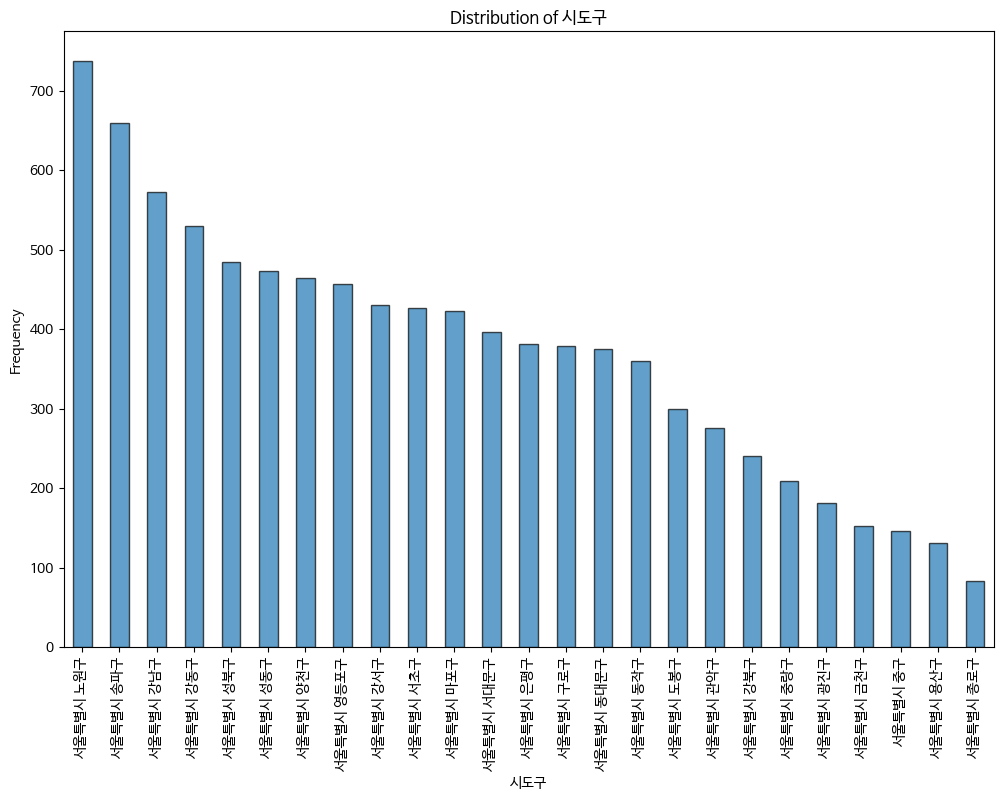

In [16]:
def extract_region(sigungus):
    regions = sigungus.split(' ')
    if len(regions) > 1:
        return regions[0] + ' ' + regions[1]
    else:
        return regions[0]

# 시도와 구를 추출하여 새로운 컬럼 생성
test_df['시도구'] = test_df['시군구'].apply(extract_region)

# 시도구 별 빈도수 계산
region_counts = test_df['시도구'].value_counts()

# 시각화
plt.figure(figsize=(12, 8))
region_counts.plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribution of 시도구')
plt.xlabel('시도구')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [18]:
# train_df와 test_df에서 시군구와 번지로 고유한 값을 생성
train_df['시군구_번지'] = train_df['시군구'] + ' ' + train_df['번지'].astype(str)
test_df['시군구_번지'] = test_df['시군구'] + ' ' + test_df['번지'].astype(str)

# 고유한 값들의 집합 생성
train_unique_set = set(train_df['시군구_번지'])
test_unique_set = set(test_df['시군구_번지'])

# train_df에는 있지만 test_df에는 없는 값 추출
unique_to_train = train_unique_set - test_unique_set

# 고유한 값들을 이용해 train_df에서 해당 데이터 추출
unique_to_train_df = train_df[train_df['시군구_번지'].isin(unique_to_train)]

# 결과 출력
unique_to_train_df.head()

,시군구,번지,아파트명,전용면적,계약년월,도로명,target,최근접_지하철역_거리,인근_지하철역_개수,최근접_버스정류장_거리,인근_버스정류장_개수,GDP,기준금리,세대별_주차대수,건설사랭크,시군구_번지
25,서울특별시 강남구 개포동,12-2,개포자이,153.80,201710,개포로109길 69,146000.0,401.837945,6.0,202.274566,2.0,1623074.1,1.25,2.367925,95.0,서울특별시 강남구 개포동 12-2
26,서울특별시 강남구 개포동,12-2,개포자이,170.32,201710,개포로109길 69,144500.0,401.837945,6.0,202.274566,2.0,1623074.1,1.25,2.367925,95.0,서울특별시 강남구 개포동 12-2
27,서울특별시 강남구 개포동,12-2,개포자이,134.30,201711,개포로109길 69,152000.0,401.837945,6.0,202.274566,2.0,1623074.1,1.50,2.367925,95.0,서울특별시 강남구 개포동 12-2
28,서울특별시 강남구 개포동,12-2,개포자이,153.80,201711,개포로109길 69,142000.0,401.837945,6.0,202.274566,2.0,1623074.1,1.50,2.367925,95.0,서울특별시 강남구 개포동 12-2
29,서울특별시 강남구 개포동,12-2,개포자이,170.32,201801,개포로109길 69,162000.0,401.837945,6.0,202.274566,2.0,1725373.4,1.50,2.367925,95.0,서울특별시 강남구 개포동 12-2


### 전용면적

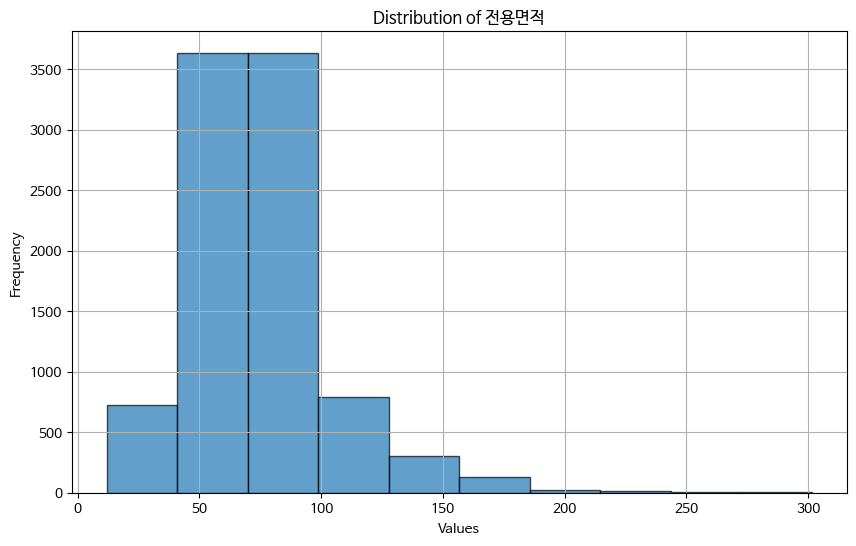

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(test_df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

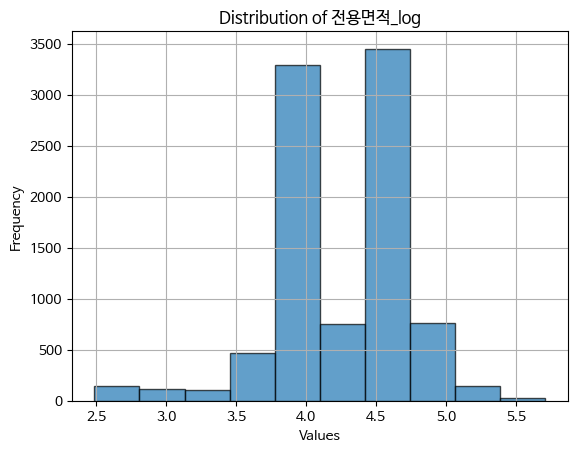

In [22]:
plt.hist(np.log(test_df['전용면적']), bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 계약년월

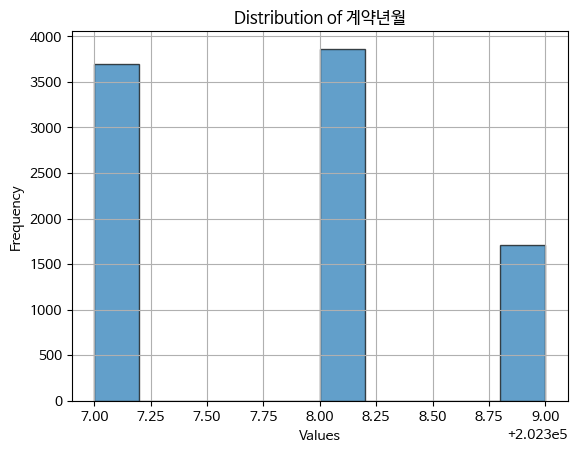

In [23]:
plt.hist(test_df['계약년월'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약년월')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [28]:
value_counts = test_df['계약년월'].value_counts()
sorted_value_counts = value_counts.sort_index()

for name, value in sorted_value_counts.items():
    print(name, value)

202307 3695
202308 3864
202309 1713


In [29]:
value_counts = train_df['계약년월'].value_counts()
sorted_value_counts = value_counts.sort_index()

for name, value in sorted_value_counts.items():
    print(name, value)

200701 4350
200702 3749
200703 5449
200704 4442
200705 3607
200706 4980
200707 5735
200708 4877
200709 4444
200710 6528
200711 5383
200712 5223
200801 5843
200802 6693
200803 10681
200804 9156
200805 7379
200806 5558
200807 3301
200808 2382
200809 1841
200810 1496
200811 1162
200812 1520
200901 3773
200902 4891
200903 5369
200904 8301
200905 6925
200906 8938
200907 7856
200908 9537
200909 7170
200910 3760
200911 3078
200912 3893
201001 4883
201002 3808
201003 3975
201004 2605
201005 2130
201006 2149
201007 2199
201008 2329
201009 2805
201010 4904
201011 6190
201012 6480
201101 7154
201102 6020
201103 5412
201104 4021
201105 3810
201106 3685
201107 4308
201108 4687
201109 4171
201110 4020
201111 3516
201112 3709
201201 2782
201202 3918
201203 4064
201204 3361
201205 3470
201206 2564
201207 2141
201208 2205
201209 3362
201210 4912
201211 4345
201212 3727
201301 3396
201302 4462
201303 6558
201304 6702
201305 6321
201306 5113
201307 3300
201308 5315
201309 7218
201310 7707
201311 5269
201

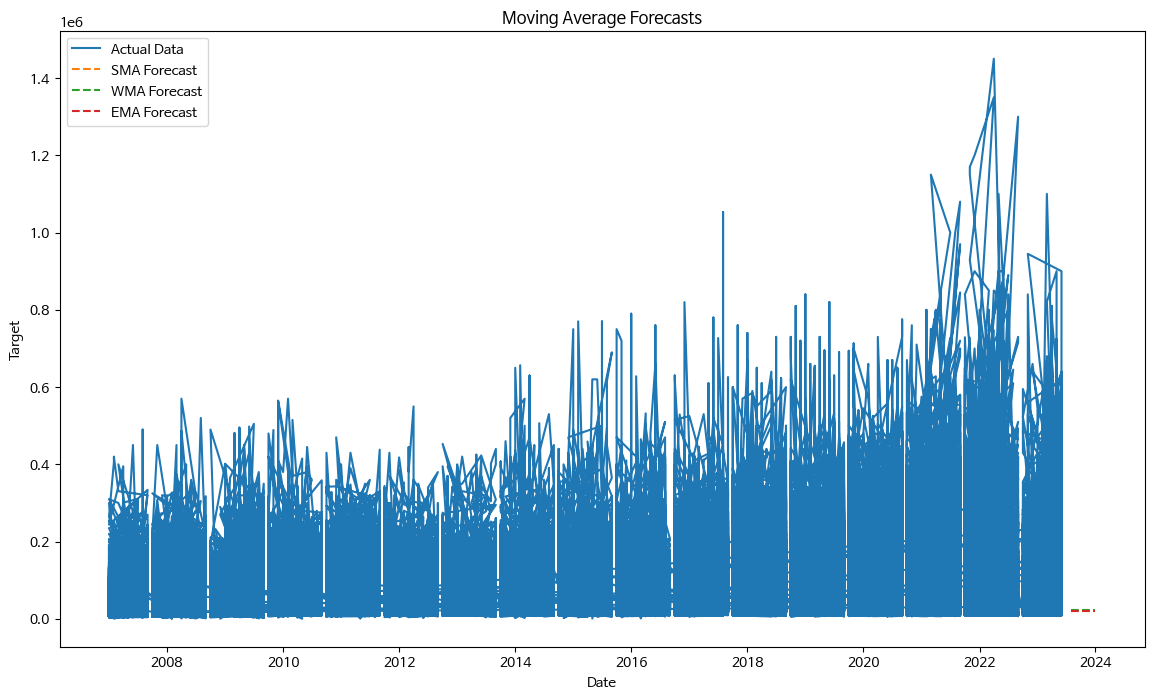

In [33]:
# 계약년월을 날짜 형식으로 변환합니다.
train_df['date'] = pd.to_datetime(train_df['계약년월'].astype(str), format='%Y%m')
train_df.set_index('date', inplace=True)

# 2023년 7월부터 12월까지의 날짜를 생성합니다.
future_dates = pd.date_range(start='2023-07-01', end='2023-12-31', freq='M')

# Simple Moving Average (SMA)
window_size = 6  # 이동평균 윈도우 크기
sma = train_df['target'].rolling(window=window_size).mean()

# Weighted Moving Average (WMA)
weights = np.arange(1, window_size+1)
wma = train_df['target'].rolling(window_size).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

# Exponential Moving Average (EMA)
ema = train_df['target'].ewm(span=window_size, adjust=False).mean()

# 예측값을 계산합니다.
sma_forecast = [sma.dropna().iloc[-1]] * len(future_dates)
wma_forecast = [wma.dropna().iloc[-1]] * len(future_dates)
ema_forecast = [ema.dropna().iloc[-1]] * len(future_dates)

# 결과를 시각화합니다.
plt.figure(figsize=(14, 8))

# 실제 데이터
plt.plot(train_df.index, train_df['target'], label='Actual Data')

# 이동평균 예측
plt.plot(future_dates, sma_forecast, label='SMA Forecast', linestyle='--')
plt.plot(future_dates, wma_forecast, label='WMA Forecast', linestyle='--')
plt.plot(future_dates, ema_forecast, label='EMA Forecast', linestyle='--')

plt.title('Moving Average Forecasts')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()